In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import newton

from datetime import datetime
from pandas.tseries.offsets import BDay
import pandas_datareader.data as pdr


In [2]:
transaction_data = pd.read_excel("./Transaction Data.xlsx")
print(transaction_data.tail())

         Date   Ticker   Asset Type    Shares  Cost/Share ($)  Commn  \
36 2025-12-03       KO  Equity  Buy  1.889407           70.80   0.33   
37 2025-12-03      BTI  Equity  Buy  2.645898           57.78   0.39   
38 2025-12-03     FANG  Equity  Buy  0.060257          158.57   0.24   
39 2025-12-03    GOOGL  Equity  Buy  0.446706          320.86   0.36   
40 2025-12-03  BTC-USD  Crypto  Buy  0.001300        92109.02   0.00   

    Total Cost ($)  
36      133.440016  
37      152.489986  
38        9.315000  
39      142.970087  
40      119.741726  


In [3]:
all_tickers = list(transaction_data['Ticker'].unique())

#Remove delisted stock
blackList = []

filt_tickers = [tick for tick in all_tickers if tick not in blackList]
print("You traded {} different stocks".format(len(all_tickers)))

You traded 11 different stocks


In [4]:
filt_tickers

['NVDA',
 'ASTS',
 'PLTR',
 'BTI',
 'FANG',
 'LYG',
 'BTC-USD',
 'SOL-USD',
 'KO',
 'SUI20947-USD',
 'GOOGL']

In [5]:
final_filtered = transaction_data[~transaction_data.Ticker.isin(blackList)]

# Collect the price history for all tickers

In [6]:
start_date = '2021-01-01'
end_date = datetime.today().strftime("%Y-%m-%d")

raw = yf.download(
    filt_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

price_data = (
    raw.swaplevel(0, 1, axis=1)   # (Ticker, Field)
       .sort_index(axis=1)
       .stack(level=0)            # Ticker → rows
       .rename_axis(["Date", "Ticker"])
       .reset_index()
       .set_index(["Ticker", "Date"])
       .sort_index()
)


In [7]:
price_data

Price                        Close       High        Low       Open  \
Ticker       Date                                                     
ASTS         2021-01-04  12.950000  13.880000  12.410000  13.610000   
             2021-01-05  13.090000  13.100000  12.160000  12.700000   
             2021-01-06  12.940000  13.390000  12.630000  12.830000   
             2021-01-07  12.780000  13.449000  12.750000  13.020000   
             2021-01-08  12.690000  12.900000  12.410000  12.800000   
...                            ...        ...        ...        ...   
SUI20947-USD 2026-01-30   1.272292   1.332633   1.237363   1.318262   
             2026-01-31   1.151215   1.275306   1.081685   1.272301   
             2026-02-01   1.103423   1.162350   1.079532   1.151256   
             2026-02-02   1.148933   1.158491   1.063454   1.103257   
             2026-02-03   1.107171   1.153307   1.074253   1.148906   

Price                          Volume  
Ticker       Date                      
ASTS         2021-01-04  1.945300e+06  
             2021-01-05  8.813000e+05  
             2021-01-06  1.029400e+06  
             2021-01-07  1.043700e+06  
             2021-01-08  8.938000e+05  
...                               ...  
SUI20947-USD 2026-01-30  1.213152e+09  
             2026-01-31  1.596565e+09  
             2026-02-01  9.636671e+08  
             2026-02-02  8.625677e+08  
             2026-02-03  9.462608e+08  

[14944 rows x 5 columns]

In [8]:
tx = transaction_data.copy()
tx["Date"] = pd.to_datetime(tx["Date"])
tx["Type"] = tx["Type"].str.upper()

# Signed shares & cash flow
tx["Signed_shares"] = tx["Shares"].where(
    tx["Type"] == "BUY", -tx["Shares"])

tx["cash_flow"] = tx["Total Cost ($)"].where(
    tx["Type"] == "SELL", -tx["Total Cost ($)"])

tx.tail(10)

,Date,Ticker,Asset,Type,Shares,Cost/Share ($),Commn,Total Cost ($),Signed_shares,cash_flow
31,2025-10-31,NVDA,Equity,BUY,0.971253,204.89,0.00,199.000027,0.971253,-199.000027
32,2025-10-31,ASTS,Equity,BUY,3.815640,80.55,0.66,306.689802,3.815640,-306.689802
33,2025-11-19,ASTS,Equity,SELL,2.570391,58.91,0.39,151.031734,-2.570391,151.031734
34,2025-12-03,NVDA,Equity,BUY,0.529187,179.59,0.24,94.796693,0.529187,-94.796693
35,2025-12-03,ASTS,Equity,BUY,1.331443,59.95,0.00,79.820008,1.331443,-79.820008
36,2025-12-03,KO,Equity,BUY,1.889407,70.80,0.33,133.440016,1.889407,-133.440016
37,2025-12-03,BTI,Equity,BUY,2.645898,57.78,0.39,152.489986,2.645898,-152.489986
38,2025-12-03,FANG,Equity,BUY,0.060257,158.57,0.24,9.315000,0.060257,-9.315000
39,2025-12-03,GOOGL,Equity,BUY,0.446706,320.86,0.36,142.970087,0.446706,-142.970087
40,2025-12-03,BTC-USD,Crypto,BUY,0.001300,92109.02,0.00,119.741726,0.001300,-119.741726


In [9]:
close_prices = price_data["Close"]
close_prices.index = close_prices.index.set_levels(
    pd.to_datetime(close_prices.index.levels[1]),
    level=1)

close_prices

Ticker        Date      
ASTS          2021-01-04    12.950000
              2021-01-05    13.090000
              2021-01-06    12.940000
              2021-01-07    12.780000
              2021-01-08    12.690000
                              ...    
SUI20947-USD  2026-01-30     1.272292
              2026-01-31     1.151215
              2026-02-01     1.103423
              2026-02-02     1.148933
              2026-02-03     1.107171
Name: Close, Length: 14944, dtype: float64

# Monthly Buying


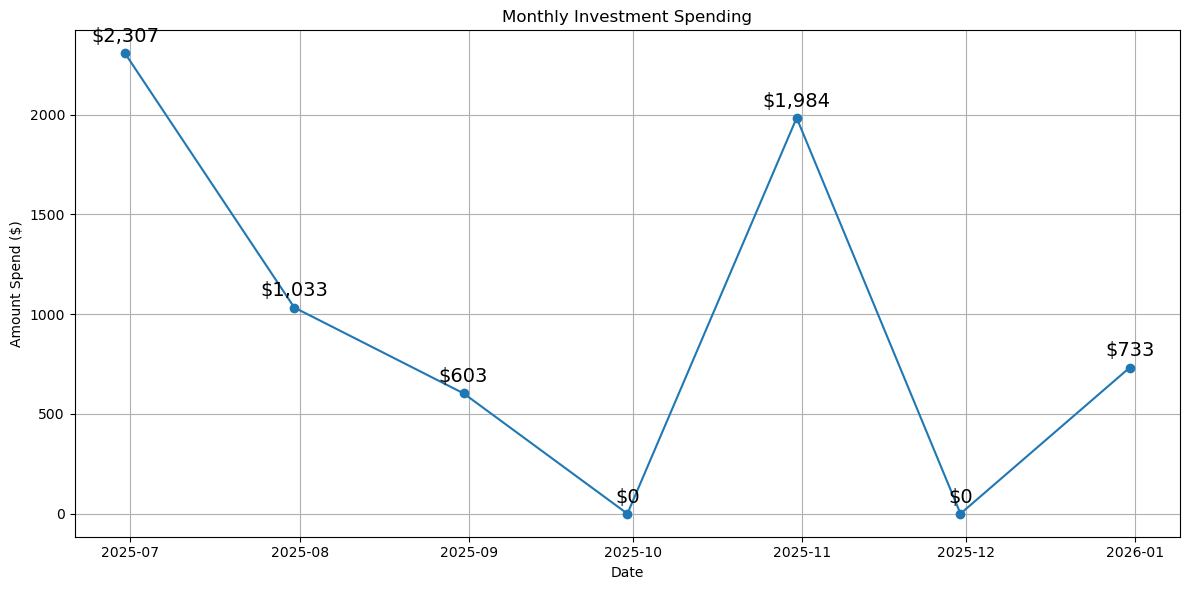

In [10]:
# Keep only Buy transactions 
buy_tx = tx[tx["Type"] == "BUY"].copy()

# Convert to monthy spending
monthly_spending = (buy_tx.set_index("Date").resample("M")["Total Cost ($)"].sum())

# Plot monthly spending
plt.figure(figsize=(12,6))
plt.plot(
    monthly_spending.index, 
    monthly_spending.values,
    marker = "o"
)
plt.title("Monthly Investment Spending")
plt.xlabel("Date")
plt.ylabel("Amount Spend ($)")
plt.grid(True)

# Add value labels
for x, y in zip(monthly_spending.index, monthly_spending.values):
    plt.annotate(
        f"${y:,.0f}",      # format number
        (x, y),            # point location
        textcoords="offset points",
        xytext=(0, 8),     # vertical offset
        ha="center",
        fontsize= 14
    )


plt.tight_layout()
plt.show()

# Net Monthly Cash Flow


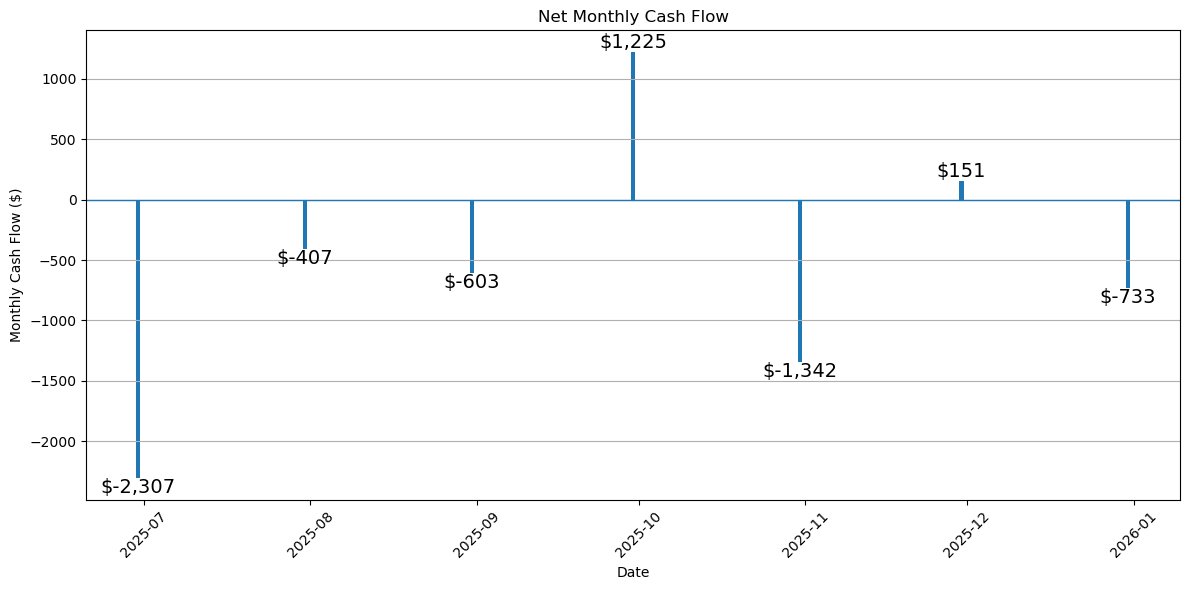

In [11]:
# Convert to Monthy Cash Flow
monthly_net_cf = (tx.set_index("Date").resample("M")["cash_flow"].sum())

# Plot
plt.figure(figsize=(12,6))

plt.bar(
    monthly_net_cf.index,
    monthly_net_cf.values
)

plt.axhline(0, linewidth=1) # Zero line
plt.title("Net Monthly Cash Flow")
plt.xlabel("Date")
plt.ylabel("Monthly Cash Flow ($)")
plt.xticks(rotation=45)
plt.grid(True, axis="y")

# Value Label
for x, y in zip(monthly_net_cf.index, monthly_net_cf.values):
    if y != 0:
        plt.text(
            x,
            y,
            f"${y:,.0f}",
            ha = "center",
            va = "bottom" if y > 0 else "top",
            fontsize = 14
        )
        
plt.tight_layout()
plt.show()

# Portfolio Value

In [12]:
### Already have transaction data tx above:
### Build daily holdings per stock

# First transaction date
start_portfolio_date = tx["Date"].min()
prices = close_prices.unstack("Ticker")
prices = prices.loc[prices.index >= start_portfolio_date]

# Remove leading NaNs per ticker (IPO-safe)
prices = prices.apply(lambda s: s.loc[s.first_valid_index():])

# Forward-fill missing prices (market-closed days)
prices = prices.ffill()

# Aggregate trades by day and ticker:
daily_trades = (
    tx.groupby(["Date", "Ticker"])["Signed_shares"]
    .sum()
    .unstack("Ticker")
    .fillna(0)
)

# Reindex to daily frequency ad forward-fill holdings
daily_trades = daily_trades.reindex(
    prices.index,
    fill_value=0
)

daily_holdings = daily_trades.cumsum()

### Some issue to remember:
# NaNs are expected due to sparse trades and incomplete price histories.
# - No trade on a date ⇒ 0 shares traded (fill NaNs with 0 before cumsum)
# - Missing prices (IPOs, holidays) ⇒ forward-fill after first valid price
# - Assets only contribute to portfolio value once a position exists
# Explicit handling prevents artificial portfolio value drops.

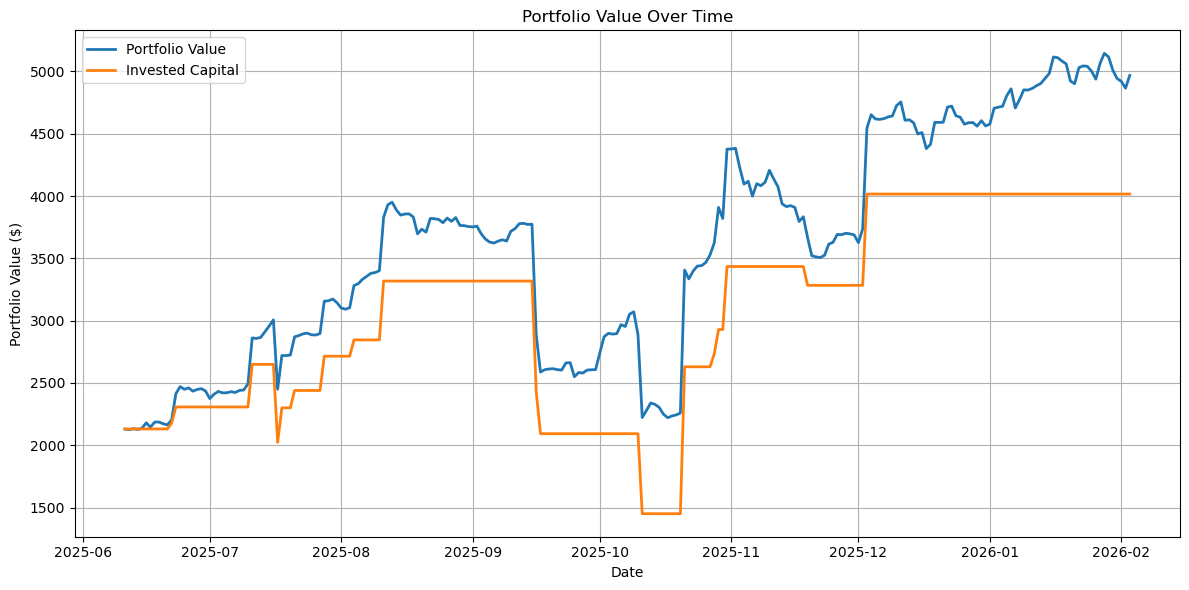

In [13]:
### Porfolio Value
position_values = (
    prices
    .where(daily_holdings != 0, 0)   # only value when held
    .fillna(0)                       # no price → no valuation
    * daily_holdings
)

portfolio_value = position_values.sum(axis=1)

### Invested Capital
# Daily net cash flow
daily_cash_flow = (
    tx.groupby("Date")["cash_flow"]
    .sum()
    .reindex(portfolio_value.index, fill_value=0)
)

# Cumulative invested capital
invested_capital = (-daily_cash_flow).cumsum()

# Plot Portfolio Value + Invested Capital
plt.figure(figsize=(12, 6))

plt.plot(
    portfolio_value.index, 
    portfolio_value.values,
    label="Portfolio Value",
    linewidth=2
)

plt.plot(
    invested_capital.index,
    invested_capital.values,
    label="Invested Capital",
    linewidth=2
)

plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Asset Distribution

In [14]:
# Take the lastest date:
latest_date = position_values.index.max()
latest_positions = position_values.loc[latest_date]

# Remove 0 value:
latest_positions = latest_positions[latest_positions > 0]

([<matplotlib.patches.Wedge at 0x21e1fa0aed0>,
 [Text(-0.48137978243659224, 0.9890770976325856, 'Crypto'),
  Text(0.48137968983250845, -0.9890771427026095, 'Equity')],
 [Text(-0.26257079041995934, 0.5394965987086829, '14.4%'),
  Text(0.26257073990864094, -0.5394966232923324, '85.6%')])

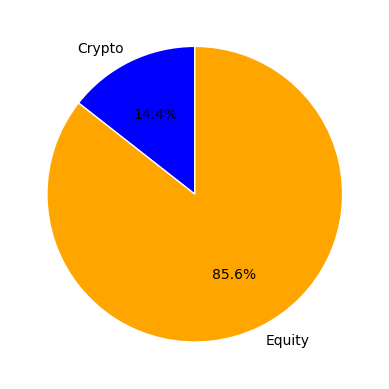

In [15]:
# Mapping asset type
ticker_asset_type = (
    tx[["Ticker", "Asset"]]
    .drop_duplicates()
    .set_index("Ticker")["Asset"]
)

# Aggregate latest portfolio value by asset type
asset_type_values = latest_positions.groupby(
    ticker_asset_type.loc[latest_positions.index]
).sum()

# Define colors by asset type (aligned with index order)
colors = [
    "orange" if asset == "Equity" else "blue"
    for asset in asset_type_values.index
]


# Distribution by Asset Type (Pie Chart - %)
plt.pie(
    asset_type_values,
    labels=asset_type_values.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white"}
)

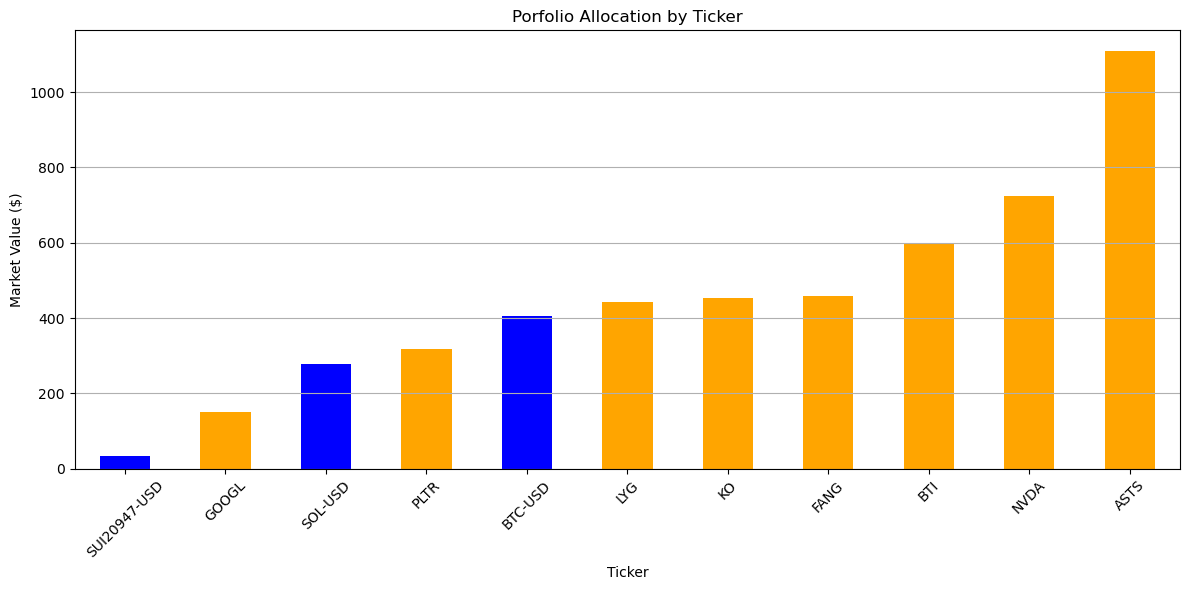

In [16]:
# Color ticker by asset
colors = [
    "orange" if ticker_asset_type[ticker] == "Equity" else "blue"
    for ticker in latest_positions.sort_values(ascending=True).index
]

# Distribution by ticker (Bar Chart - Value)
plt.figure(figsize=(12,6))
latest_positions.sort_values(ascending=True).plot(
    kind="bar",
    color=colors
)

plt.title("Porfolio Allocation by Ticker")
plt.xlabel("Ticker")
plt.ylabel("Market Value ($)")
plt.xticks(rotation=45)
plt.grid(True, axis="y")

plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_33328\1847303673.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(ticker_asset_type, axis=1)


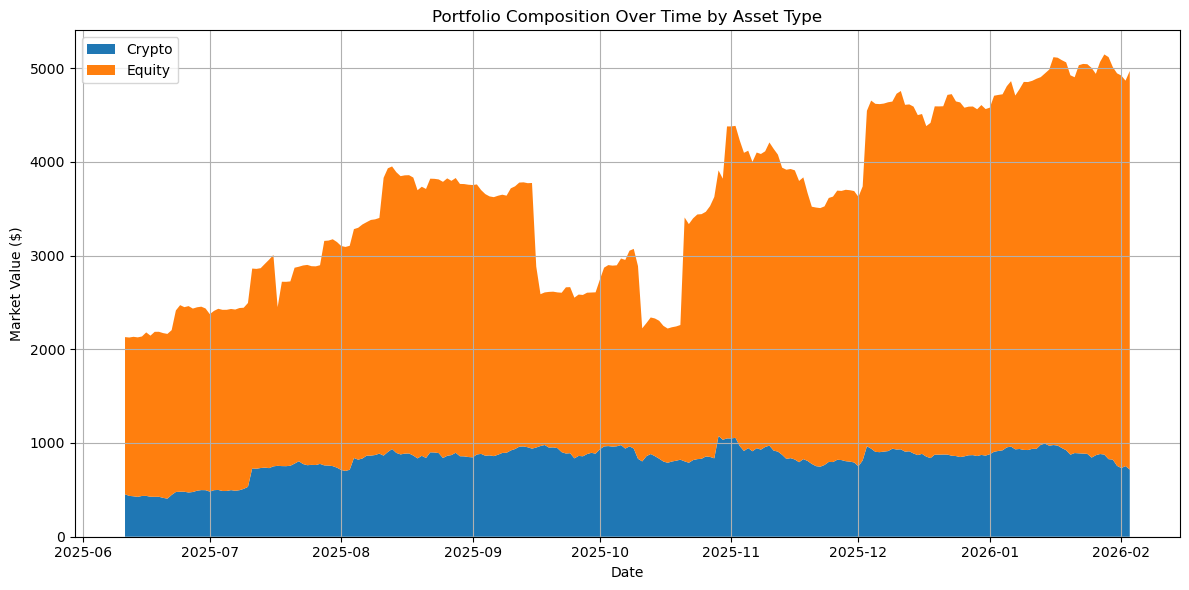

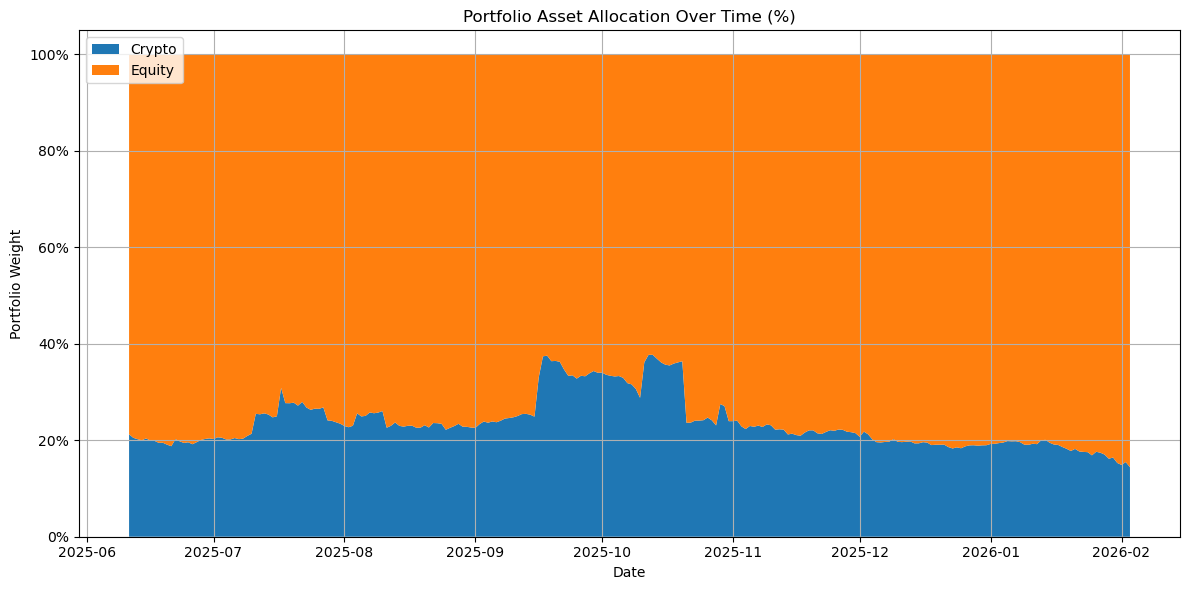

In [17]:
# Aggregate portfolio position values by Asset Type over time.
asset_type_over_time = (
    position_values
    .groupby(ticker_asset_type, axis=1)
    .sum()
)

# Plot portfolio composition over time using a stacked area chart.
plt.figure(figsize=(12, 6))
plt.stackplot(
    asset_type_over_time.index,
    asset_type_over_time.T.values,
    labels=asset_type_over_time.columns
)

plt.title("Portfolio Composition Over Time by Asset Type")
plt.xlabel("Date")
plt.ylabel("Market Value ($)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot Stacked % Over time

# Convert market values to portfolio weights (row-wise)
asset_type_pct = asset_type_over_time.div(
    asset_type_over_time.sum(axis=1),
    axis=0
)
asset_type_pct = asset_type_pct.fillna(0)

plt.figure(figsize=(12, 6))
plt.stackplot(
    asset_type_pct.index,
    asset_type_pct.T.values,
    labels=asset_type_pct.columns
)

plt.title("Portfolio Asset Allocation Over Time (%)")
plt.xlabel("Date")
plt.ylabel("Portfolio Weight")
plt.legend(loc="upper left")
plt.grid(True)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f"{y:.0%}")
)

plt.tight_layout()
plt.show()


# Profit and Loss

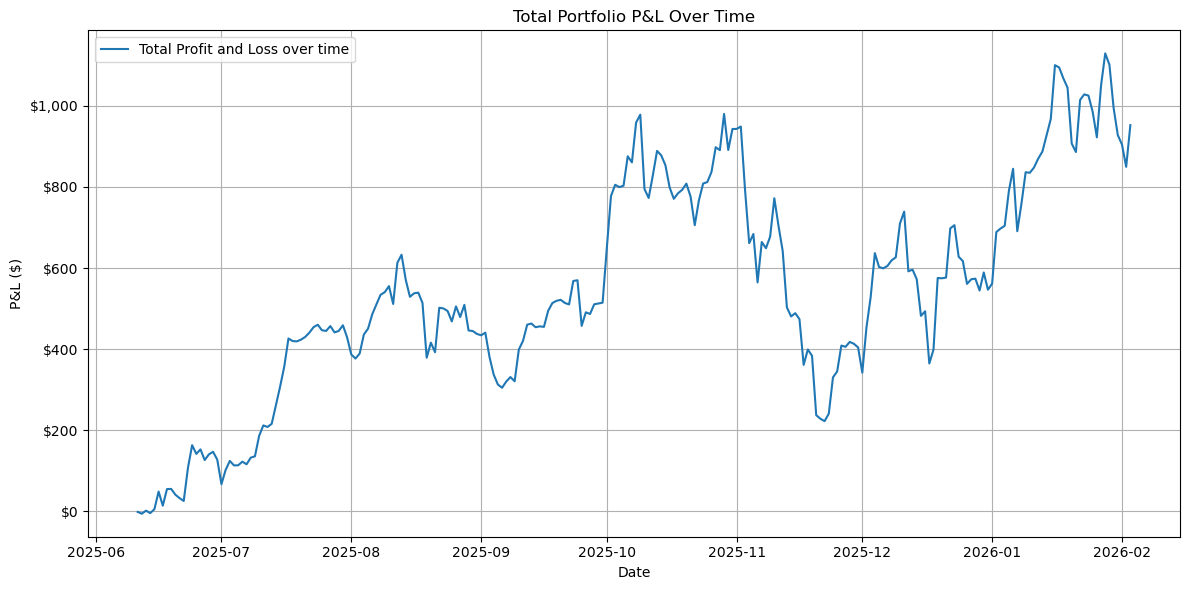

In [18]:
# Total P&L
total_pnl = portfolio_value - invested_capital

# Plot
plt.figure(figsize=(12,6))

plt.plot(
    total_pnl.index,
    total_pnl.values,
    label="Total Profit and Loss over time"
)

plt.title("Total Portfolio P&L Over Time")
plt.xlabel("Date")
plt.ylabel("P&L ($)")
plt.legend()
plt.grid(True)

# Format y-axis as dollars (no scientific notation)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x:,.0f}")
)

plt.tight_layout()
plt.show()

# Return over time

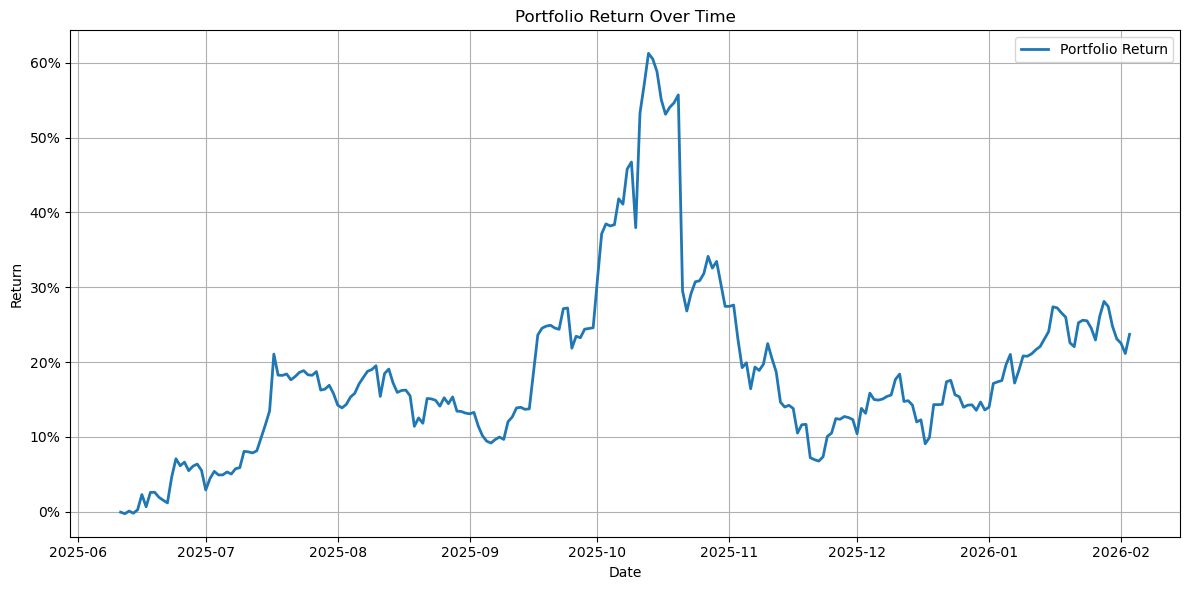

In [19]:
# Return Calculation
portfolio_return = total_pnl / invested_capital
portfolio_return = portfolio_return.replace([float("inf"), -float("inf")], 0)
portfolio_return = portfolio_return.fillna(0)

# Plot
plt.figure(figsize=(12, 6))

plt.plot(
    portfolio_return.index,
    portfolio_return.values,
    linewidth=2,
    label="Portfolio Return"
)

plt.title("Portfolio Return Over Time")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)

# Format as percentage
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f"{y:.0%}")
)

plt.tight_layout()
plt.show()

In [20]:
# Money-weighted Return
def xirr(cash_flows):
    """
    cash_flows: pandas Series with Date index and cash flow values
                (negative = investment, positive = withdrawal)
    """
    dates = cash_flows.index
    amounts = cash_flows.values

    def npv(rate):
        return sum(
            amt / (1 + rate) ** ((d - dates[0]).days / 365)
            for amt, d in zip(amounts, dates)
        )

    return newton(npv, 0.1)

# Transaction cash flows (negative = buy, positive = sell)
cash_flows = tx.groupby("Date")["cash_flow"].sum().copy()

# Terminal portfolio value date
terminal_date = portfolio_value.index[-1]

# Add terminal portfolio value as a final inflow
if terminal_date in cash_flows.index:
    cash_flows.loc[terminal_date] += portfolio_value.iloc[-1]
else:
    cash_flows.loc[terminal_date] = portfolio_value.iloc[-1]

cash_flows = cash_flows.sort_index()

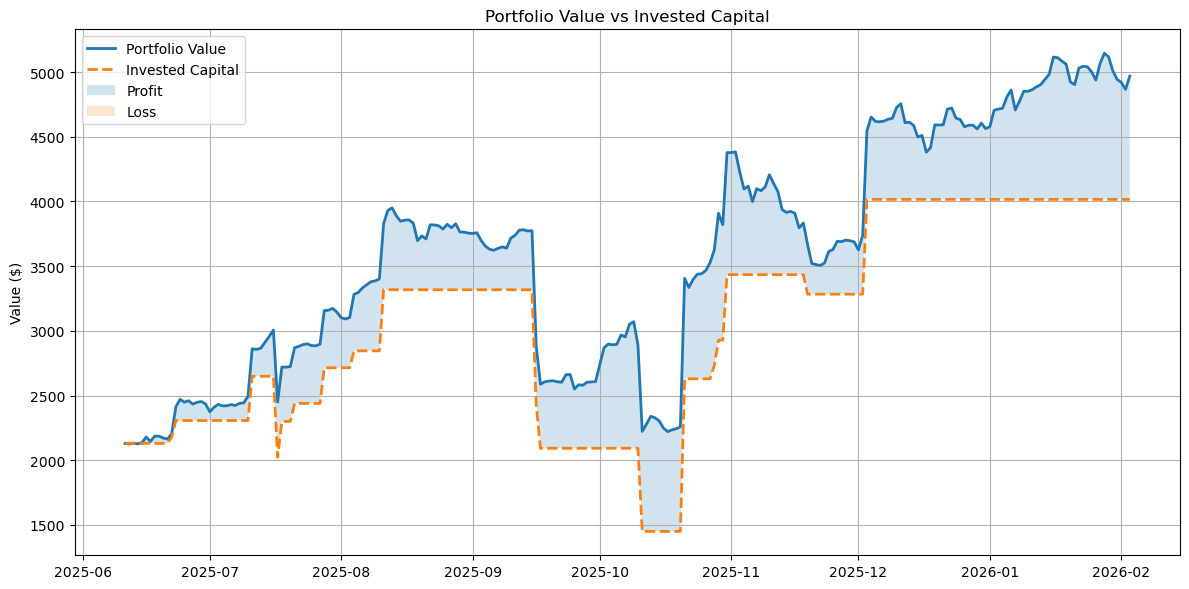

Portfolio XIRR: 52.84%


In [21]:
### All-in-one performance chart
plt.figure(figsize=(12, 6))

plt.plot(portfolio_value, label="Portfolio Value", linewidth=2)
plt.plot(invested_capital, label="Invested Capital", linestyle="--", linewidth=2)

# Shade profit/loss
plt.fill_between(
    portfolio_value.index,
    invested_capital,
    portfolio_value,
    where=(portfolio_value >= invested_capital),
    alpha=0.2,
    label="Profit"
)

plt.fill_between(
    portfolio_value.index,
    invested_capital,
    portfolio_value,
    where=(portfolio_value < invested_capital),
    alpha=0.2,
    label="Loss"
)

plt.title("Portfolio Value vs Invested Capital")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Money-Weighted Return Calculate above
portfolio_xirr = xirr(cash_flows)
print(f"Portfolio XIRR: {portfolio_xirr:.2%}")

# Realised & Unrealised Breakdown

In [22]:
# Transaction table
tx_sorted = tx.sort_values(["Ticker","Date"]).copy()
tx_sorted["Realised_PnL"] = 0.0

# Realised P&L Caluculation
def compute_realised_pnl_avg_cost(df):
    shares_held = 0.0
    cost_basis = 0.0
    realised = []

    for _, row in df.iterrows():
        qty = row["Shares"]
        price = row["Cost/Share ($)"]
        trade_type = row["Type"]

        if trade_type == "BUY":
            # Add to inventory
            shares_held += qty
            cost_basis += qty * price
            realised.append(0.0)

        elif trade_type == "SELL":
            if shares_held <= 0:
                realised.append(0.0)
                continue

            avg_cost = cost_basis / shares_held

            # Realised P&L on sold shares
            pnl = (price - avg_cost) * qty
            realised.append(pnl)

            # Remove sold inventory at average cost
            shares_held -= qty
            cost_basis -= avg_cost * qty

        else:
            realised.append(0.0)

    df = df.copy()
    df["Realised_PnL"] = realised
    return df

tx_realised = (
    tx_sorted
    .groupby("Ticker", group_keys=False)
    .apply(compute_realised_pnl_avg_cost)
)

# Aggregate realised P&L over time
daily_realised_pnl = (
    tx_realised.groupby("Date")["Realised_PnL"]
    .sum()
    .reindex(portfolio_value.index, fill_value=0)
)

cumulative_realised_pnl = daily_realised_pnl.cumsum()

# Unrealised P&L
unrealised_pnl = total_pnl - cumulative_realised_pnl

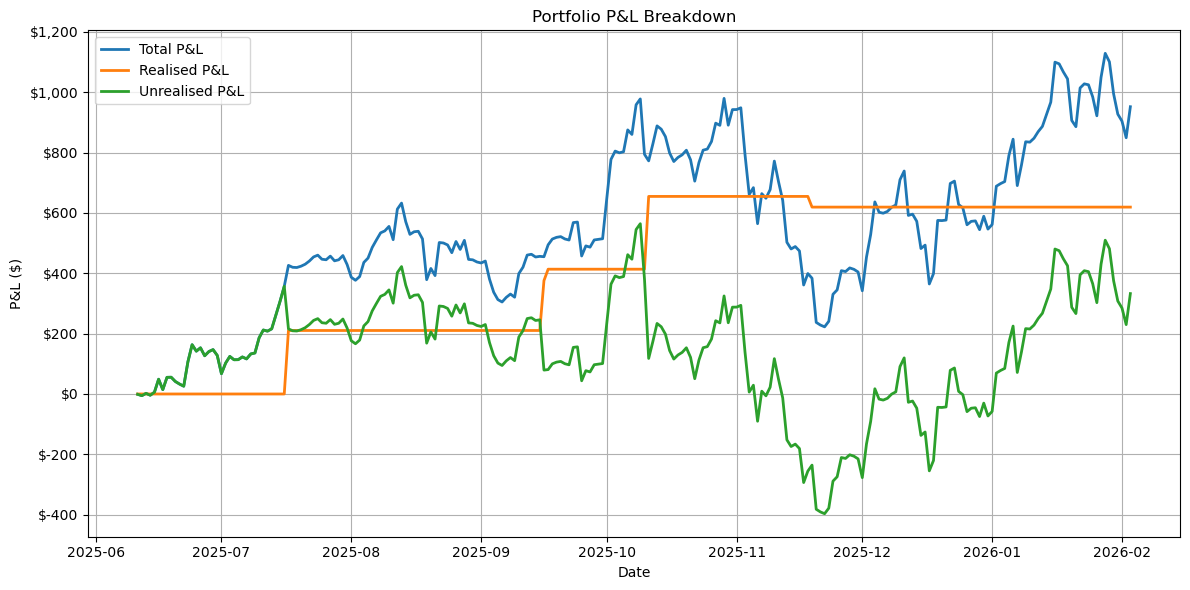

In [23]:
# Plot realised vs unrealised vs total P&L
plt.figure(figsize=(12, 6))

plt.plot(total_pnl, label="Total P&L", linewidth=2)
plt.plot(cumulative_realised_pnl, label="Realised P&L", linewidth=2)
plt.plot(unrealised_pnl, label="Unrealised P&L", linewidth=2)

plt.title("Portfolio P&L Breakdown")
plt.xlabel("Date")
plt.ylabel("P&L ($)")
plt.legend()
plt.grid(True)

plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"${x:,.0f}")
)

plt.tight_layout()
plt.show()